In [1]:
import climate_learn as cl
from climate_learn.data.processing.nc2npz import convert_nc2npz
from IPython.display import HTML
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/home/qi/.conda/envs/llm_edge/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
cl.data.download_weatherbench(
    dst="/data/qi/climate/ClimateLearn/temperature",
    dataset="era5",
    variable="temperature_850"
)

In [ ]:
cl.data.download_weatherbench(
    dst="/data/qi/climate/ClimateLearn/geopotential",
    dataset="era5",
    variable="geopotential_500"
)

In [2]:
convert_nc2npz(
    root_dir="/data/qi/climate/ClimateLearn",
    save_dir="/data/qi/climate/ClimateLearn/processed",
    variables=["temperature", "geopotential"],
    start_train_year=1979,
    start_val_year=2015,
    start_test_year=2017,
    end_year=2018,
    num_shards=16
)

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


In [10]:
dm = cl.data.IterDataModule(
    task="direct-forecasting",
    inp_root_dir="/data/qi/climate/ClimateLearn/processed",
    out_root_dir="/data/qi/climate/ClimateLearn/processed",
    in_vars=["temperature", "geopotential"],
    out_vars=["temperature", "geopotential"],
    src="era5",
    subsample=6,
    pred_range=24,
    history=3,
    batch_size=32
)
dm.setup()

In [11]:
climatology = cl.load_forecasting_module(
    data_module=dm, architecture="climatology"
)
persistence = cl.load_forecasting_module(
    data_module=dm, architecture="persistence"
)

trainer = pl.Trainer()
trainer.test(climatology, dm)
trainer.test(persistence, dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading architecture: climatology
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize
Loading architecture: persistence
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: de

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/lat_acc:aggregate   │    0.002286637867969616    │
│ test/lat_acc:geopotential  │   -0.0020452924620714425   │
│  test/lat_acc:temperature  │    0.006618568198010681    │
│  test/lat_rmse:aggregate   │     534.9848123508632      │
│ test/lat_rmse:geopotential │     1064.5965083803287     │
│ test/lat_rmse:temperature  │     5.373116321397814      │
└────────────────────────────┴────────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 43/? [00:00<00:00, 78.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/lat_acc:aggregate   │     0.8103965440378824     │
│ test/lat_acc:geopotential  │     0.8191593687462576     │
│  test/lat_acc:temperature  │     0.8016337193295074     │
│  test/lat_rmse:aggregate   │     303.2970449929333      │
│ test/lat_rmse:geopotential │     603.4956555367604      │
│ test/lat_rmse:temperature  │     3.0984344491063727     │
└────────────────────────────┴────────────────────────────┘

[{'test/lat_rmse:temperature': 3.0984344491063727,
  'test/lat_rmse:geopotential': 603.4956555367604,
  'test/lat_rmse:aggregate': 303.2970449929333,
  'test/lat_acc:temperature': 0.8016337193295074,
  'test/lat_acc:geopotential': 0.8191593687462576,
  'test/lat_acc:aggregate': 0.8103965440378824}]

0it [00:00, ?it/s]


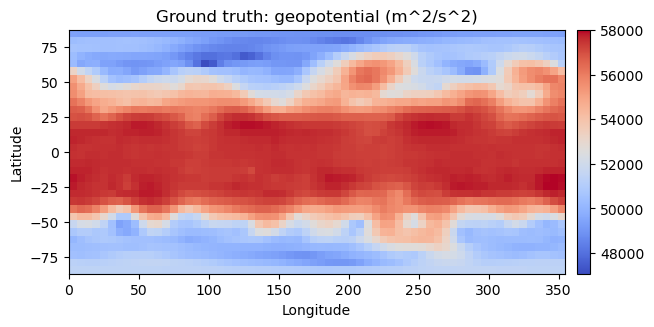

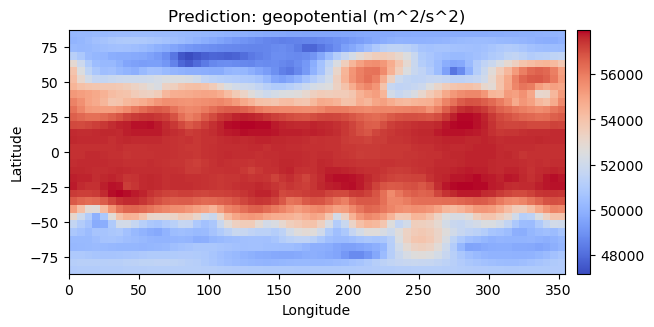

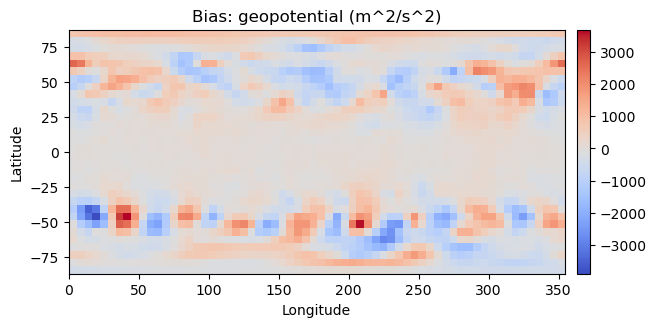

In [7]:
denorm = persistence.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    persistence,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="geopotential",
    src="era5",
    index=0
)

In [8]:
HTML(in_graphic.to_jshtml())

43it [00:00, 86.44it/s]


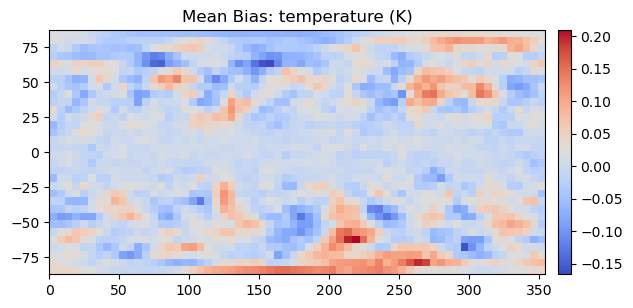

In [9]:
cl.utils.visualize_mean_bias(
    dm,
    persistence,
    out_transform=denorm,
    variable="temperature",
    src="era5"
)

In [10]:
resnet = cl.load_forecasting_module(
    data_module=dm,
    architecture="rasp-theurey-2020"
)

Loading architecture: rasp-theurey-2020
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


In [27]:
pl.seed_everything(0)
default_root_dir = f"resnet_forecasting_24hrs"
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/lat_mse:aggregate"
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(
        monitor=early_stopping,
        patience=5
    ),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    )
]
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="gpu" if torch.cuda.is_available() else None,
    devices=[0] if torch.cuda.is_available() else None,
    max_epochs=25,
    precision="16"
)

Seed set to 0
Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(resnet, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ net  │ ResNet │  5.7 M │ train │
└───┴──────┴────────┴────────┴───────┘

Trainable params: 5.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.7 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 238                                                                                         
Modules in eval mode: 0

After fitting the model, we can test it using the best checkpoint saved during training.

In [29]:
trainer.test(resnet, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at /home/qi/LLM_Reasoning/neuron_distill/climate/resnet_forecasting_24hrs/checkpoints/epoch_002.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/qi/LLM_Reasoning/neuron_distill/climate/resnet_forecasting_24hrs/checkpoints/epoch_002.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/lat_acc:aggregate   │     0.9678886881675451     │
│ test/lat_acc:geopotential  │     0.9839172617644224     │
│  test/lat_acc:temperature  │     0.951860114570667      │
│  test/lat_rmse:aggregate   │     91.13425584497122      │
│ test/lat_rmse:geopotential │     180.7506186911815      │
│ test/lat_rmse:temperature  │     1.5178929987610101     │
└────────────────────────────┴────────────────────────────┘

[{'test/lat_rmse:temperature': 1.5178929987610101,
  'test/lat_rmse:geopotential': 180.7506186911815,
  'test/lat_rmse:aggregate': 91.13425584497122,
  'test/lat_acc:temperature': 0.951860114570667,
  'test/lat_acc:geopotential': 0.9839172617644224,
  'test/lat_acc:aggregate': 0.9678886881675451}]

As before, let's visualize the bias of our deep learning model on the first sample of the testing set (the mean bias computation will take a while, even on GPU).

0it [00:00, ?it/s]


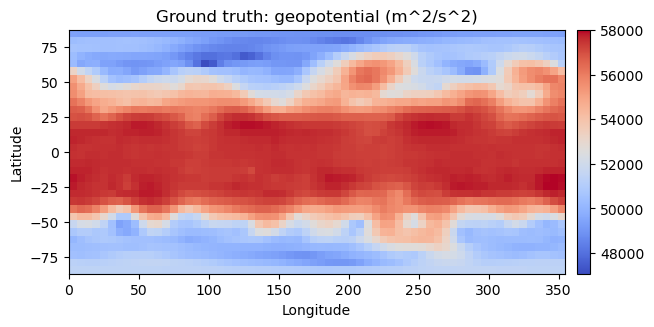

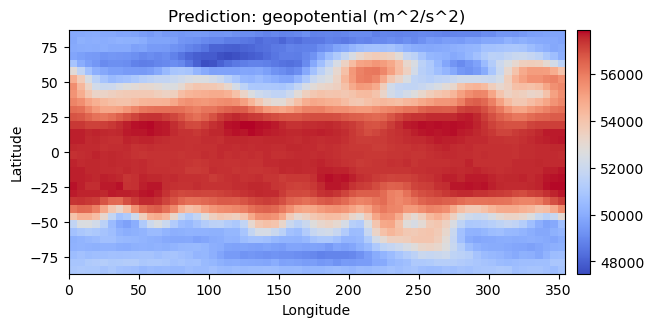

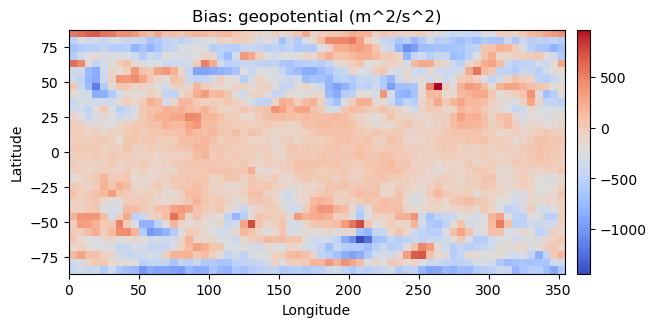

In [30]:
denorm = resnet.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    resnet.to(device="cuda:0"),
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="geopotential",
    src="era5",
    index=0
)

In [3]:
dm2 = cl.data.IterDataModule(
    task="downscaling",
    inp_root_dir="/data/qi/climate/ClimateLearn/processed",
    out_root_dir="/data/qi/climate/ClimateLearn/processed",
    in_vars=["temperature", "geopotential"],
    out_vars=["temperature", "geopotential"],
    src="era5",
    subsample=6,
    pred_range=24,
    history=3,
    batch_size=32
)
dm2.setup()

In [ ]:
U_net = cl.load_downscaling_module(
    data_module=dm2,
    architecture="unet"
)



pl.seed_everything(0)
default_root_dir = f"U_net_forecasting_24hrs"
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/mse:aggregate" 
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(
        monitor=early_stopping,
        patience=5
    ),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    )
]
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="gpu" if torch.cuda.is_available() else None,
    devices=[0] if torch.cuda.is_available() else None,
    max_epochs=15,
    precision="16"
)

Seed set to 0


Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading architecture: unet
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize


In [17]:
trainer.fit(U_net, datamodule=dm2)

/home/qi/.conda/envs/llm_edge/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/qi/LLM_Reasoning/neuron_distill/climate/U_net_forecasting_24hrs/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ net  │ Sequential │  5.8 M │ train │
└───┴──────┴────────────┴────────┴───────┘

Trainable params: 5.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.8 M                                                                                                
Total estimated model params size (MB): 23                                                                         
Modules in train mode: 425                                                                                         
Modules in eval mode: 0

`Trainer.fit` stopped: `max_epochs=15` reached.


In [18]:
trainer.test(U_net, datamodule=dm2, ckpt_path="best")

Restoring states from the checkpoint path at /home/qi/LLM_Reasoning/neuron_distill/climate/U_net_forecasting_24hrs/checkpoints/epoch_013.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/qi/LLM_Reasoning/neuron_distill/climate/U_net_forecasting_24hrs/checkpoints/epoch_013.ckpt


/home/qi/.conda/envs/llm_edge/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/qi/.conda/envs/llm_edge/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/mean_bias:aggregate   │     -8.724079132080078      │
│ test/mean_bias:geopotential │     -17.43084716796875      │
│ test/mean_bias:temperature  │    -0.01731185056269169     │
│   test/pearson:aggregate    │     0.9998722076416016      │
│  test/pearson:geopotential  │     0.9998757243156433      │
│  test/pearson:temperature   │      0.999868631362915      │
│     test/rmse:aggregate     │     28.440786361694336      │
│   test/rmse:geopotential    │      56.63967514038086      │
│    test/rmse:temperature    │     0.24189986288547516     │
└─────────────────────────────┴─────────────────────────────┘

[{'test/rmse:temperature': 0.24189986288547516,
  'test/rmse:geopotential': 56.63967514038086,
  'test/rmse:aggregate': 28.440786361694336,
  'test/pearson:temperature': 0.999868631362915,
  'test/pearson:geopotential': 0.9998757243156433,
  'test/pearson:aggregate': 0.9998722076416016,
  'test/mean_bias:temperature': -0.01731185056269169,
  'test/mean_bias:geopotential': -17.43084716796875,
  'test/mean_bias:aggregate': -8.724079132080078}]